# Object detection

https://huggingface.co/docs/datasets/object_detection

In [ ]:
from datasets import load_dataset

ds = load_dataset("cppe-5")
ds

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
})

In [ ]:
example = ds['train'][0]
example

{'image_id': 15,
 'image': <PIL.Image.Image image mode=RGB size=943x663>,
 'width': 943,
 'height': 663,
 'objects': {'id': [114, 115, 116, 117],
  'area': [3796, 1596, 152768, 81002],
  'bbox': [[302.0, 109.0, 73.0, 52.0],
   [810.0, 100.0, 57.0, 28.0],
   [160.0, 31.0, 248.0, 616.0],
   [741.0, 68.0, 202.0, 401.0]],
  'category': [4, 4, 0, 0]}}

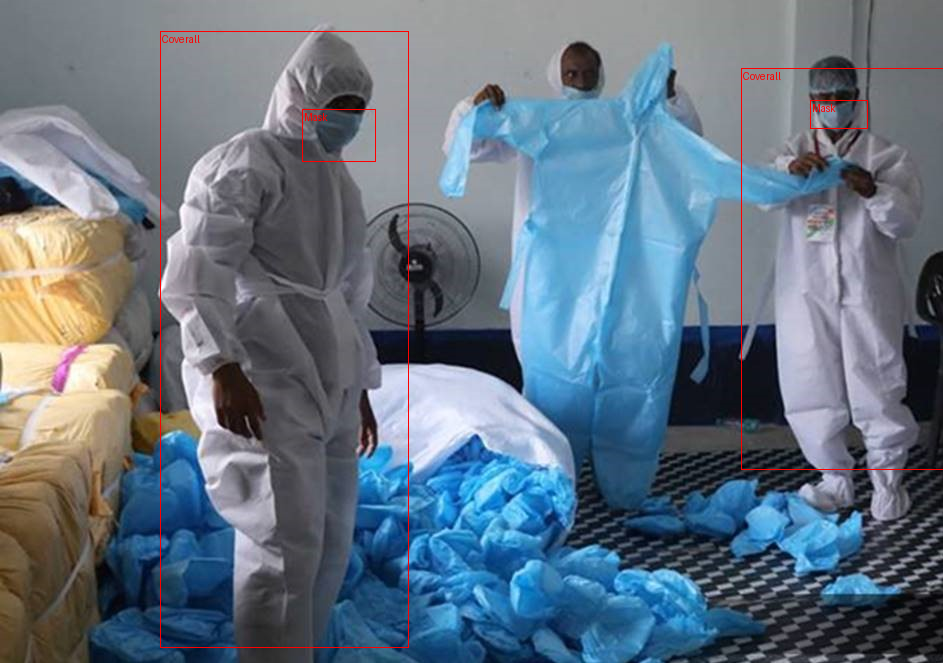

In [ ]:
import torch
from torchvision.ops import box_convert
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import pil_to_tensor, to_pil_image

categories = ds['train'].features['objects'].feature['category']

boxes_xywh = torch.tensor(example['objects']['bbox'])
boxes_xyxy = box_convert(boxes_xywh, 'xywh', 'xyxy')
labels = [categories.int2str(x) for x in example['objects']['category']]
to_pil_image(
    draw_bounding_boxes(
        pil_to_tensor(example['image']),
        boxes_xyxy,
        colors="red",
        labels=labels,
    )
)

In [ ]:
import albumentations
import numpy as np

transform = albumentations.Compose([
    albumentations.Resize(480, 480),
    albumentations.HorizontalFlip(p=1.0),
    albumentations.RandomBrightnessContrast(p=1.0),
], bbox_params=albumentations.BboxParams(format='coco',  label_fields=['category']))

image = np.array(example['image'])
out = transform(
    image=image,
    bboxes=example['objects']['bbox'],
    category=example['objects']['category'],
)

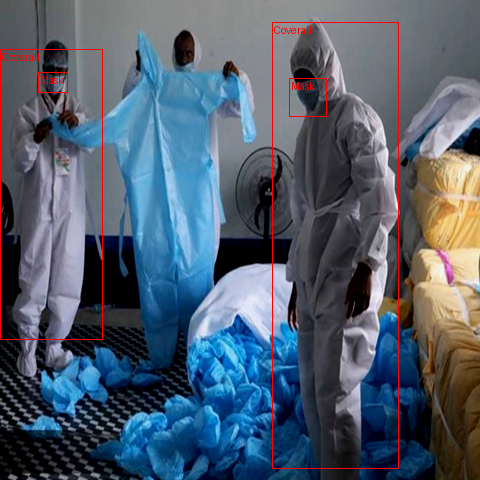

In [ ]:
image = torch.tensor(out['image']).permute(2, 0, 1)
boxes_xywh = torch.stack([torch.tensor(x) for x in out['bboxes']])
boxes_xyxy = box_convert(boxes_xywh, 'xywh', 'xyxy')
labels = [categories.int2str(int(x)) for x in out['category']]
to_pil_image(
    draw_bounding_boxes(
        image,
        boxes_xyxy,
        colors='red',
        labels=labels
    )
)

In [ ]:
def transforms(examples):
    images, bboxes, categories = [], [], []
    for image, objects in zip(examples['image'], examples['objects']):
        image = np.array(image.convert("RGB"))
        out = transform(
            image=image,
            bboxes=objects['bbox'],
            category=objects['category']
        )
        images.append(torch.tensor(out['image']).permute(2, 0, 1))
        bboxes.append(torch.tensor(out['bboxes']))
        categories.append(out['category'])
    return {'image': images, 'bbox': bboxes, 'category': categories}

In [ ]:
ds['train'].set_transform(transforms)

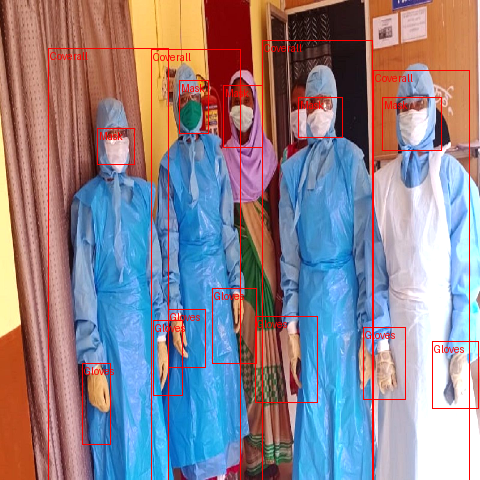

In [ ]:
example = ds['train'][10]
to_pil_image(
    draw_bounding_boxes(
        example['image'],
        box_convert(example['bbox'], 'xywh', 'xyxy'),
        colors='red',
        labels=[categories.int2str(int(x)) for x in example['category']]
    )
)